In [2]:
import torch
from torchvision import transforms, datasets

In [5]:
GPP_transform = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

C:\Users\jkcshop\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:562: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +


In [3]:
data_dir = "./dataset-resized"

In [6]:
data = datasets.ImageFolder(root=data_dir,transform = GPP_transform)

In [13]:
dataset_loader = torch.utils.data.DataLoader(data,
                                             batch_size=20, shuffle=True,
                                             num_workers=4)

In [15]:
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic',
           'trash']

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) 

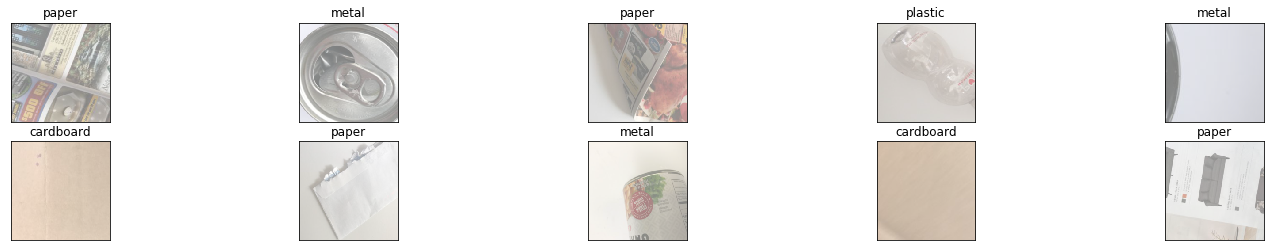

In [19]:
# obtain one batch of training images
dataiter = iter(dataset_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for i in np.arange(10):
    axs = fig.add_subplot(2, 10/2,i+1, xticks=[], yticks=[])
    imshow(images[i])
    axs.set_title(classes[labels[i]])

In [10]:
import numpy as np